In [2]:
import torch
import torch.nn.functional as F
import math
import pickle
import copy

In [113]:
def scaled_dot_product_attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)

    # 1. calculate dot products QK
    attention_scores = torch.matmul(query, key.transpose(-2, -1))

    # 2. scale the scores
    attention_scores = attention_scores / math.sqrt(d_k)
    
    # 3. apply mask if given
    if mask is not None:
        attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
    
    # 4. apply softmax
    attention_weights = F.softmax(attention_scores, dim=-1)

    # 5. apply dropout
    if dropout is not None:
        attention_weights = dropout(attention_weights)

    # 6.  multiply weights by values
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [114]:
batch_size = 1
seq_len = 4
d_k = 8
d_v = 8

query = torch.randn(batch_size, seq_len, d_k)
key = torch.randn(batch_size, seq_len, d_k)
value = torch.randn(batch_size, seq_len, d_v)

output, attention_weights = scaled_dot_product_attention(query, key, value)

print("Input Query Shape:", query.shape)
print("Input Shape:", key.shape)
print("Input Value Shape:", value.shape)
print("\nOutput Shape:", output.shape)
print("Attention Weights Shape:", attention_weights.shape)
print("\nSample Attention Weights (first batch element):\n", attention_weights[0])

Input Query Shape: torch.Size([1, 4, 8])
Input Shape: torch.Size([1, 4, 8])
Input Value Shape: torch.Size([1, 4, 8])

Output Shape: torch.Size([1, 4, 8])
Attention Weights Shape: torch.Size([1, 4, 4])

Sample Attention Weights (first batch element):
 tensor([[0.0470, 0.0276, 0.0644, 0.8611],
        [0.3128, 0.5033, 0.0350, 0.1489],
        [0.6519, 0.1229, 0.0984, 0.1268],
        [0.3301, 0.2653, 0.2178, 0.1867]])


In [6]:
def sinusodial_embeddings(max_len, d_model):
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1).float()
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

sinusodial_embeddings(10000, 512)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
          1.0366e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
          2.0733e-04,  1.0000e+00],
        ...,
        [ 4.3692e-01,  8.9950e-01, -8.2362e-01,  ...,  4.7636e-01,
          8.6054e-01,  5.0939e-01],
        [ 9.9297e-01,  1.1834e-01, -2.9231e-03,  ...,  4.7627e-01,
          8.6059e-01,  5.0930e-01],
        [ 6.3609e-01, -7.7162e-01,  8.2029e-01,  ...,  4.7617e-01,
          8.6064e-01,  5.0921e-01]])

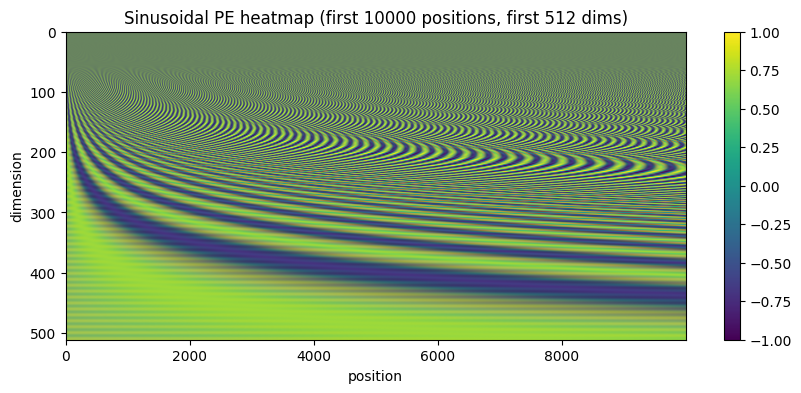

In [22]:
import math
import torch
import matplotlib.pyplot as plt

def sinusodial_embeddings(max_len, d_model):
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1).float()
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

pe = sinusodial_embeddings(1000000, 512)

N = 10000
D = 512
x = pe[:N, :D].T.cpu().numpy()

plt.figure(figsize=(10, 4))
plt.imshow(x, aspect="auto")
plt.xlabel("position")
plt.ylabel("dimension")
plt.title(f"Sinusoidal PE heatmap (first {N} positions, first {D} dims)")
plt.colorbar()
plt.show()

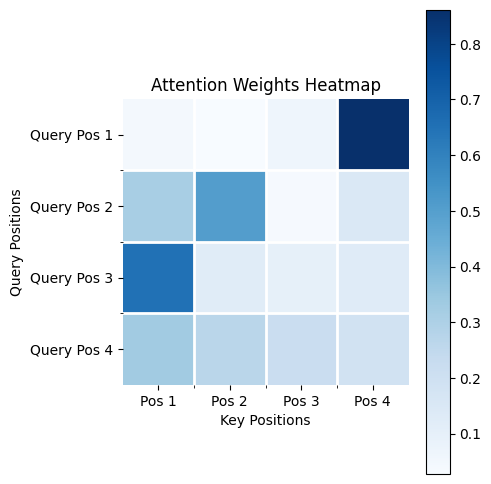

In [4]:
import matplotlib.pyplot as plt
import torch

att = attention_weights[0].detach().cpu().numpy()
n_q, n_k = att.shape

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(att, cmap='Blues', interpolation='nearest', aspect='equal')

ax.set_xticks(range(n_k))
ax.set_yticks(range(n_q))
ax.set_xticklabels([f'Pos {i+1}' for i in range(n_k)])
ax.set_yticklabels([f'Query Pos {i+1}' for i in range(n_q)])

ax.set_xticks([x - 0.5 for x in range(1, n_k)], minor=True)
ax.set_yticks([y - 0.5 for y in range(1, n_q)], minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.colorbar(im, ax=ax)
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.title('Attention Weights Heatmap')
plt.tight_layout()
plt.show()


In [116]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.0):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
    
    def split_heads(self, x):
        B, L, D = x.size()
        x = x.view(B, L, self.num_heads, self.head_dim)
        x = x.transpose(1, 2)

        return x
    
    def combine_heads(self, x):
        B, H, L, Hd = x.size()
        x = x.transpose(1,2).contiguous()
        x = x.view(B, L, H * Hd)
        return x
    
    def forward(self, q, k, v, mask=None):
        Q = self.W_q(q)
        K = self.W_k(k)
        V = self.W_v(v)

        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        if mask is not None and mask.dim() == 3:
            mask = mask.unsqueeze(1)
        
        attn_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask=mask)
        attn_output = self.combine_heads(attn_output)
        attn_output = self.W_o(attn_output)
        attn_output = self.dropout(attn_output)

        return attn_output, attn_weights

In [117]:
# position-wise feed forward network

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [118]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output, _ = self.self_attn(q=self.norm1(x), k=self.norm1(x), v=self.norm1(x), mask=mask)
        x = x + self.dropout1(attn_output)
        
        ff_output = self.feed_forward(self.norm2(x))
        x = x + self.dropout2(ff_output)

        return x

In [119]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_output=None, tgt_mask=None, memory_mask=None):
        self_attn_input = self.norm1(x)
        self_attn_output, _ = self.self_attn(
            q=self_attn_input,
            k=self_attn_input,
            v=self_attn_input,
            mask=tgt_mask
        )
        x = x + self.dropout1(self_attn_output)

        if enc_output is not None:
            cross_attn_input = self.norm2(x)
            cross_attn_output, _ = self.cross_attn(
                q=cross_attn_input,
                k=enc_output,
                v=enc_output,
                mask=memory_mask
            )
            x = x + self.dropout2(cross_attn_output)

        ff_output = self.feed_forward(self.norm3(x))
        x = x + self.dropout3(ff_output)

        return x

In [120]:
class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, n_layer, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(n_layer)])
        self.norm = nn.LayerNorm(d_model)

    def _build_causal_mask(self, x):
        B, T, _ = x.size()
        m = torch.tril(torch.ones((T, T), device=x.device, dtype=torch.bool))
        m = m.unsqueeze(0).unsqueeze(1).expand(B, 1, T, T)
        return m

    def forward(self, x):
        tgt_mask = self._build_causal_mask(x)
        for layer in self.layers:
            x = layer(x, tgt_mask=tgt_mask)
        x = self.norm(x)
        return x

In [121]:
class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, n_layer, dropout=0.1, max_seq_len=512):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, d_model)
        self.wpe = nn.Embedding(max_seq_len, d_model)
        self.decoder = Decoder(d_model, num_heads, d_ff, n_layer, dropout)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.wte.weight

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def get_device(self):
        return next(self.parameters()).device

    def forward(self, idx, targets=None):
        B, T = idx.size()
        x = self.wte(idx)
        pos = torch.arange(T, device=idx.device).unsqueeze(0).expand(B, T)
        x = x + self.wpe(pos)
        x = self.decoder(x)
        logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss
    
    @torch.inference_mode()
    def generate(self, tokens, max_tokens, temperature=1.0, top_k=None, seed=42):
        rng = None
        device = self.get_device()
        if temperature > 0:
            rng = torch.Generator(device=device)
            rng.manual_seed(seed)
        ids = torch.tensor([tokens], dtype=torch.long, device=device) # add batch dim
        for _ in range(max_tokens):
            logits, _ = self.forward(ids)
            logits = logits[:, -1, :]
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            if temperature > 0:
                logits = logits / temperature
                probs = F.softmax(logits, dim=-1)
                next_ids = torch.multinomial(probs, num_samples=1, generator=rng)
            else:
                next_ids = torch.argmax(logits, dim=-1, keepdim=True)
            ids = torch.cat((ids, next_ids), dim=1)
            token = next_ids.item()
            yield token

config

In [122]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 512
learning_rate = 1e-3
max_iters = 8000
eval_interval = 500
eval_iters = 200
block_size = 512

data loader

In [123]:
import numpy as np
import torch
import pandas as pd
from datasets import load_dataset
import tiktoken

dataset = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")

enc = tiktoken.get_encoding("gpt2")

def tokenize(example):
    return {"input_ids": enc.encode(example["text"], allowed_special=set())}

tokenized = dataset.map(tokenize, remove_columns=["text"])

def create_chunks(dataset_split, chunk_size=256):
    all_tokens = []
    for example in dataset_split:
        all_tokens.extend(example["input_ids"])

    all_tokens = np.array(all_tokens)

    n_chunks = len(all_tokens) // chunk_size
    all_tokens = all_tokens[:n_chunks * chunk_size]
    chunks = all_tokens.reshape(-1, chunk_size)

    return chunks

train_data = create_chunks(tokenized["train"], chunk_size=256)
test_data = create_chunks(tokenized["test"], chunk_size=256)
val_data = create_chunks(tokenized["validation"], chunk_size=256)

train_data = torch.tensor(train_data, dtype=torch.long, device=device)
test_data = torch.tensor(test_data, dtype=torch.long, device=device)
val_data = torch.tensor(val_data, dtype=torch.long, device=device)

print(f"Train: {train_data.shape}")  # (num_sequences, 256)
print(f"Val: {val_data.shape}")

Train: torch.Size([460625, 256])
Val: torch.Size([965, 256])


training

In [124]:
model = GPT(
    vocab_size=enc.n_vocab,
    d_model=512,
    num_heads=8,
    n_layer=8,
    d_ff=2048,
    dropout=0.1
)

print(f"Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")

Parameters: 59.63M


In [125]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model = torch.compile(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)
scaler = torch.amp.GradScaler(enabled=(device == "cuda"))
patience = 5
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0

@torch.no_grad()
def estimate_loss(data, num_batches):
    model.eval()
    losses = []
    for _ in range(num_batches):
        ix = torch.randint(len(data), (batch_size,))
        x, y = data[ix, :-1], data[ix, 1:]
        with torch.amp.autocast(device, dtype=torch.bfloat16):
            _, loss = model(x, y)
        losses.append(loss.item())
    model.train()
    return sum(losses) / len(losses)

for iter_num in range(max_iters):
    ix = torch.randint(len(train_data), (batch_size, ))
    x = train_data[ix, :-1]
    y = train_data[ix, 1:]

    with torch.amp.autocast(device, dtype=torch.bfloat16):
        _, loss = model(x,y)
    
    optimizer.zero_grad(set_to_none=True)
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    scaler.step(optimizer)
    scaler.update()

    train_losses.append(loss.item())

    # Evaluation
    if iter_num % eval_interval == 0 or iter_num == max_iters - 1:
        train_loss = estimate_loss(train_data, eval_iters)
        val_loss = estimate_loss(val_data, eval_iters)
        val_losses.append(val_loss)
        
        print(f"step {iter_num:5d} | train loss {train_loss:.4f} | val loss {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            
            # Save checkpoint
            torch.save({
                'step': iter_num,
                'model_state': best_model_state,
                'optimizer_state': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, 'best_model.pt')
            print(f"  ↳ New best model saved!")
        else:
            patience_counter += 1
            print(f"  ↳ No improvement ({patience_counter}/{patience})")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping at step {iter_num}")
            break

step     0 | train loss 10.1458 | val loss 10.1305
  ↳ New best model saved!
step   500 | train loss 4.9680 | val loss 4.9295
  ↳ New best model saved!
step  1000 | train loss 4.0962 | val loss 4.1056
  ↳ New best model saved!
step  1500 | train loss 3.7611 | val loss 3.7769
  ↳ New best model saved!
step  2000 | train loss 3.5964 | val loss 3.6359
  ↳ New best model saved!
step  2500 | train loss 3.4969 | val loss 3.5538
  ↳ New best model saved!
step  3000 | train loss 3.4261 | val loss 3.4921
  ↳ New best model saved!
step  3500 | train loss 3.3736 | val loss 3.4574
  ↳ New best model saved!
step  4000 | train loss 3.3318 | val loss 3.4193
  ↳ New best model saved!
step  4500 | train loss 3.2960 | val loss 3.3972
  ↳ New best model saved!
step  5000 | train loss 3.2718 | val loss 3.3772
  ↳ New best model saved!
step  5500 | train loss 3.2426 | val loss 3.3578
  ↳ New best model saved!
step  6000 | train loss 3.2252 | val loss 3.3437
  ↳ New best model saved!
step  6500 | train loss

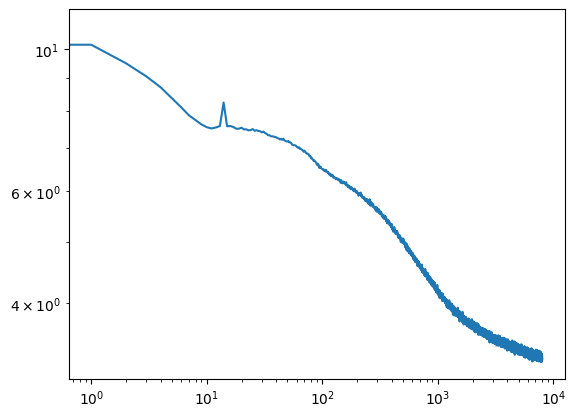

In [131]:
plt.plot(train_losses)
plt.yscale("log")
plt.xscale("log")
plt.show()

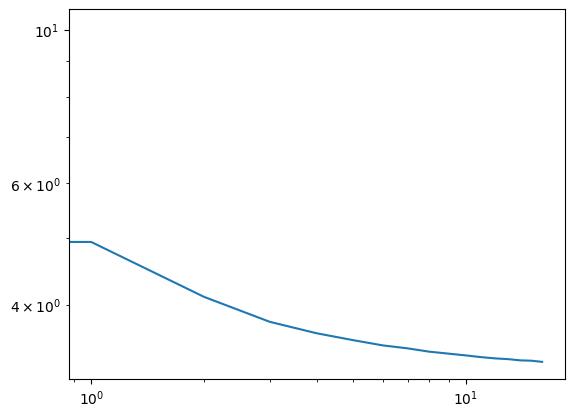

In [132]:
plt.plot(val_losses)
plt.yscale("log")
plt.xscale("log")
plt.show()

In [138]:
model.eval()
tokens = enc.encode("Taylor Swift is")
generated = list(model.generate(tokens, max_tokens=200, temperature=1, top_k=25))
print(enc.decode(tokens + generated))
model.train()

Taylor Swift is known to be the protagonist in the series , a character created by former team character and writer George " The " Hills on the ABC television series The X @-@ Files , and a member of the series of the series . The series continues a tradition for some young fans that are now playing in the series after watching video games like The X @-@ Files at the time . Although there are many fans who have expressed worries about the series , the episode " Monster 's Ball " received a generally positive reception from television critics . 
 Despite being critically acclaimed , " Monster , the " Monster 's Ball " was a generally well @-@ received episode , though it proved to be a " little less satisfying " than a series with some humor . Several writers have praised the episode 's audio commentary and the show 's writing . The episode was included in the series DVD set , released in 2004 , and the first season DVD set , entitled " The X @-@ Files " , was


OptimizedModule(
  (_orig_mod): GPT(
    (wte): Embedding(50257, 512)
    (wpe): Embedding(512, 512)
    (decoder): Decoder(
      (layers): ModuleList(
        (0-7): 8 x DecoderLayer(
          (self_attn): MultiHeadAttention(
            (W_q): Linear(in_features=512, out_features=512, bias=True)
            (W_k): Linear(in_features=512, out_features=512, bias=True)
            (W_v): Linear(in_features=512, out_features=512, bias=True)
            (W_o): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (cross_attn): MultiHeadAttention(
            (W_q): Linear(in_features=512, out_features=512, bias=True)
            (W_k): Linear(in_features=512, out_features=512, bias=True)
            (W_v): Linear(in_features=512, out_features=512, bias=True)
            (W_o): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forwa